# Scraping Heisius Brieven metadata from Huygens ING resources



__external dependencies__: requests, lxml

__steps__:

+ retrieve the table of contents 
+ parse the toc xml
+ write to a csv file


In [8]:
import requests
import os
import re
from csv import DictWriter
from lxml import etree 

# these are the names of the books

hein = """	ING Book Service 01_158
ING Book Service 02_163
ING Book Service 03_169
ING Book Service 04_177
ING Book Service 05_183
ING Book Service 06_189
ING Book Service 07_194
ING Book Service 08_198
ING Book Service 09_204
ING Book Service 10_207
ING Book Service 11_214
ING Book Service 12_221
ING Book Service 13_224
ING Book Service 14_226
ING Book Service 15_227
ING Book Service 16_240
ING Book Service 17_243
ING Book Service 18_244
ING Book Service 19_247
"""

ah = re.sub('\n\s?ING Book Service ', '\n,', hein)
hein.replace('\tING Book Service ', '')


input = ah.split('\n,')
input = [i.strip() for i in input]

# define an output directory
# change this to suit your own computer

outdir = '/Users/rikhoekstra/Downloads/heinsius_brieven'

baseurl = 'http://resources.huygens.knaw.nl/retroapp/service_heinsius/%s/TableOfContents'

# get items from resources

for item in input:
    url = baseurl % item
    doc = requests.get(url)   
    fl = doc.text
    outfl = open(os.path.join(outdir, item + '.xml'), 'w')
    outfl.write(fl)
    outfl.close()



## Parsing

We parse the xml using the (fast) lxml parser

In [12]:
# parser for the xml 

def parsefl(items):
    rows = []
    fieldnames = ['n', 
              'page',
              'from',
              'to',
              'd',
              'm',
              'y']
    for i in items:
        row = {}
        ch = i.getchildren()
        for e in ch:
            if e.tag in ['n', 'page']:
                row[e.tag] = e.text
            elif e.tag == 'title':
                for t in e.getchildren():
                    if t.tag == 'date':
                        for d in t.getchildren():
                            row[d.tag] = d.text
                    else:
                        row[t.tag] = t.text
        row = { key : value for key,value in row.items() if key in fieldnames}
        rows.append(row)
    return rows

# now write them to records for csv
outrows = []
for fl in os.listdir(outdir):
    if os.path.splitext(fl)[1] == '.xml':
        infl = os.path.join(outdir, fl)
        doc = etree.parse(infl)
        root = doc.getroot()
        items = [item for item in root if item.tag == 'item']    
        result = parsefl(items)
        outrows.extend(result)

        


In [13]:
## Write to csv file

[{'m': '1', 'page': '1', 'to': 'Welland', 'n': '1', 'y': '1703', 'd': '1'}, {'m': '1', 'page': '1', 'from': 'Noyelle', 'y': '1703', 'd': '1', 'n': '2'}, {'m': '1', 'page': '1', 'from': 'Buys', 'y': '1703', 'd': '1', 'n': '3'}, {'m': '1', 'page': '1', 'from': 'Goudet', 'y': '1703', 'd': '2', 'n': '4'}, {'m': '1', 'page': '2', 'from': 'Marlborough', 'y': '1703', 'd': '2', 'n': '5'}, {'m': '1', 'page': '2', 'from': 'Van der Poel', 'y': '1703', 'd': '2', 'n': '6'}, {'m': '1', 'page': '2', 'from': "Sauniere de l'Hermitage", 'y': '1703', 'd': '2', 'n': '7'}, {'m': '1', 'page': '2', 'from': 'Tilly', 'y': '1703', 'd': '2', 'n': '8'}, {'m': '1', 'page': '3', 'from': 'Trognee', 'y': '1703', 'd': '2', 'n': '9'}, {'m': '1', 'page': '4', 'from': 'Van Vrijbergen', 'y': '1703', 'd': '2', 'n': '10'}]


In [ ]:
fieldnames = ['n', 
              'page',
              'from',
              'to',
              'd',
              'm',
              'y']
              
outfl = os.path.join(outdir, 'heinbrieven.csv')

out = open(outfl, 'w')

w = DictWriter(out, fieldnames)
w.writeheader()
w.writerows(outrows)
out.close()

<IPython.core.display.Javascript object>


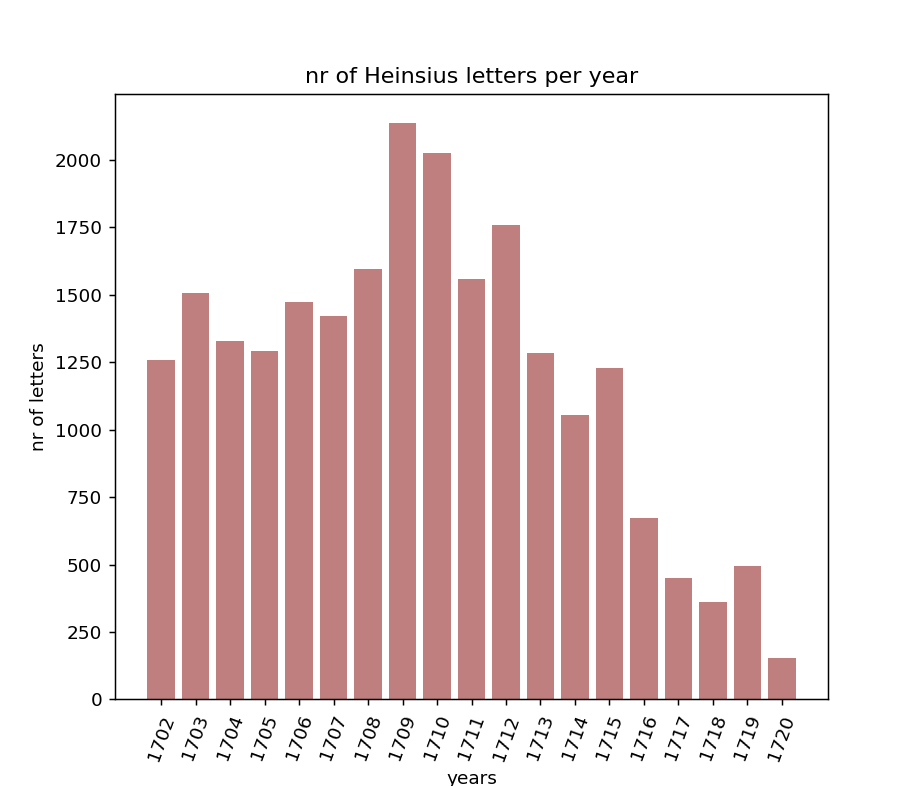

In [41]:
# now visualize
%matplotlib notebook

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

objects = Counter([row.get('y') for row in outrows if row.get('y')])
years = list(objects.items())
years.sort()
vales = [r[1] for r in years]
y_pos = np.arange(len(years))
plt.bar(y_pos, vales, color='maroon', align='center', alpha=0.5)
plt.xticks(rotation=70)
plt.xticks(y_pos, [r[0] for r in years])
plt.ylabel('nr of letters')
plt.xlabel('years')
plt.title('nr of Heinsius letters per year')


 
plt.show()